<a href="https://colab.research.google.com/github/colefreeman/call_center_forecast/blob/main/Call_Center_Forecast_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install numbers-parser

In [ ]:
pip install roman

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from numbers_parser import Document
import datetime
from datetime import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy


In [31]:
columns = ['index', 'incoming_calls', 'answered_calls', 'answer_rate', 'abandoned_calls', 'avg_answer_speed',
           'avg_talk_duration', 'avg_waiting_time', 'service_level']

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
url = '/content/drive/MyDrive/call_center_data.csv'
df = pd.read_csv(url, names=columns, header=1)
df = df.drop(['index'], axis = 1)
df.head()

,incoming_calls,answered_calls,answer_rate,abandoned_calls,avg_answer_speed,avg_talk_duration,avg_waiting_time,service_level
0,217,204,0.94,13,0:00:17,0:02:14,0:02:45,0.76
1,200,182,0.91,18,0:00:20,0:02:22,0:06:55,0.73
2,216,198,0.92,18,0:00:18,0:02:38,0:03:50,0.74
3,155,145,0.94,10,0:00:15,0:02:29,0:03:12,0.80
4,37,37,1.00,0,0:00:03,0:02:06,0:00:35,0.97


In [36]:
#import date table
doc = Document("/content/drive/MyDrive/time_series_date_table.numbers")
sheets = doc.sheets()
tables = sheets[0].tables()
data = tables[0].rows(values_only=True)
df_date = pd.DataFrame(data, columns=["Date", "Day_of_week"])
df_date.head()

,Date,Day_of_week
0,01/01/2015,Thursday
1,01/02/2015,Friday
2,01/05/2015,Monday
3,01/06/2015,Tuesday
4,01/07/2015,Wednesday


In [42]:
#Join kaggle data table to date table
df_merged = df_date.join(df, how='left')
df_merged.head()

,Date,Day_of_week,incoming_calls,answered_calls,answer_rate,abandoned_calls,avg_answer_speed,avg_talk_duration,avg_waiting_time,service_level
0,01/01/2015,Thursday,217,204,0.94,13,0:00:17,0:02:14,0:02:45,0.76
1,01/02/2015,Friday,200,182,0.91,18,0:00:20,0:02:22,0:06:55,0.73
2,01/05/2015,Monday,216,198,0.92,18,0:00:18,0:02:38,0:03:50,0.74
3,01/06/2015,Tuesday,155,145,0.94,10,0:00:15,0:02:29,0:03:12,0.80
4,01/07/2015,Wednesday,37,37,1.00,0,0:00:03,0:02:06,0:00:35,0.97


In [43]:
df_merged['Date'] = pd.to_datetime(df_merged.Date)
df_merged['year'] = df_merged['Date'].dt.year
df_merged['month'] = df_merged['Date'].dt.month
df_merged['day'] = df_merged['Date'].dt.dayofweek
df_merged.head()

,Date,Day_of_week,incoming_calls,answered_calls,answer_rate,abandoned_calls,avg_answer_speed,avg_talk_duration,avg_waiting_time,service_level,year,month,day
0,2015-01-01,Thursday,217,204,0.94,13,0:00:17,0:02:14,0:02:45,0.76,2015,1,3
1,2015-01-02,Friday,200,182,0.91,18,0:00:20,0:02:22,0:06:55,0.73,2015,1,4
2,2015-01-05,Monday,216,198,0.92,18,0:00:18,0:02:38,0:03:50,0.74,2015,1,0
3,2015-01-06,Tuesday,155,145,0.94,10,0:00:15,0:02:29,0:03:12,0.80,2015,1,1
4,2015-01-07,Wednesday,37,37,1.00,0,0:00:03,0:02:06,0:00:35,0.97,2015,1,2


In [44]:
df_visual_analysis = df_merged.copy()
df_visual_analysis.head()

,Date,Day_of_week,incoming_calls,answered_calls,answer_rate,abandoned_calls,avg_answer_speed,avg_talk_duration,avg_waiting_time,service_level,year,month,day
0,2015-01-01,Thursday,217,204,0.94,13,0:00:17,0:02:14,0:02:45,0.76,2015,1,3
1,2015-01-02,Friday,200,182,0.91,18,0:00:20,0:02:22,0:06:55,0.73,2015,1,4
2,2015-01-05,Monday,216,198,0.92,18,0:00:18,0:02:38,0:03:50,0.74,2015,1,0
3,2015-01-06,Tuesday,155,145,0.94,10,0:00:15,0:02:29,0:03:12,0.80,2015,1,1
4,2015-01-07,Wednesday,37,37,1.00,0,0:00:03,0:02:06,0:00:35,0.97,2015,1,2


In [45]:
#Convert time hh:mm:ss into total seconds
df_merged['avg_answer_speed'] = pd.to_timedelta(df_merged['avg_answer_speed']).dt.total_seconds().map('{:,.2f}'.format).astype(float)
df_merged['avg_talk_duration'] = pd.to_timedelta(df_merged['avg_talk_duration']).dt.total_seconds().map('{:,.2f}'.format).astype(float)
df_merged['avg_waiting_time'] = pd.to_timedelta(df_merged['avg_waiting_time']).dt.total_seconds().map('{:,.2f}'.format)
df_merged.avg_waiting_time = df_merged.avg_waiting_time.apply(lambda x : x.replace(',','')).astype(float)
df_merged.head(10)

,Date,Day_of_week,incoming_calls,answered_calls,answer_rate,abandoned_calls,avg_answer_speed,avg_talk_duration,avg_waiting_time,service_level,year,month,day
0,2015-01-01,Thursday,217,204,0.94,13,17.0,134.0,165.0,0.76,2015,1,3
1,2015-01-02,Friday,200,182,0.91,18,20.0,142.0,415.0,0.73,2015,1,4
2,2015-01-05,Monday,216,198,0.92,18,18.0,158.0,230.0,0.74,2015,1,0
3,2015-01-06,Tuesday,155,145,0.94,10,15.0,149.0,192.0,0.80,2015,1,1
4,2015-01-07,Wednesday,37,37,1.00,0,3.0,126.0,35.0,0.97,2015,1,2
5,2015-01-08,Thursday,315,304,0.97,11,18.0,95.0,157.0,0.77,2015,1,3
6,2015-01-09,Friday,252,244,0.97,8,13.0,110.0,122.0,0.82,2015,1,4
7,2015-01-12,Monday,213,205,0.96,8,10.0,130.0,202.0,0.88,2015,1,0
8,2015-01-13,Tuesday,219,200,0.91,19,15.0,138.0,372.0,0.79,2015,1,1
9,2015-01-14,Wednesday,371,348,0.94,23,19.0,100.0,209.0,0.74,2015,1,2


In [46]:
df_lgbm = df_merged.copy()
df_lgbm.head()

,Date,Day_of_week,incoming_calls,answered_calls,answer_rate,abandoned_calls,avg_answer_speed,avg_talk_duration,avg_waiting_time,service_level,year,month,day
0,2015-01-01,Thursday,217,204,0.94,13,17.0,134.0,165.0,0.76,2015,1,3
1,2015-01-02,Friday,200,182,0.91,18,20.0,142.0,415.0,0.73,2015,1,4
2,2015-01-05,Monday,216,198,0.92,18,18.0,158.0,230.0,0.74,2015,1,0
3,2015-01-06,Tuesday,155,145,0.94,10,15.0,149.0,192.0,0.80,2015,1,1
4,2015-01-07,Wednesday,37,37,1.00,0,3.0,126.0,35.0,0.97,2015,1,2


In [47]:
df_visual_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251 entries, 0 to 1250
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1251 non-null   datetime64[ns]
 1   Day_of_week        1251 non-null   object        
 2   incoming_calls     1251 non-null   int64         
 3   answered_calls     1251 non-null   int64         
 4   answer_rate        1251 non-null   float64       
 5   abandoned_calls    1251 non-null   int64         
 6   avg_answer_speed   1251 non-null   object        
 7   avg_talk_duration  1251 non-null   object        
 8   avg_waiting_time   1251 non-null   object        
 9   service_level      1251 non-null   float64       
 10  year               1251 non-null   int64         
 11  month              1251 non-null   int64         
 12  day                1251 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memory us

In [48]:
df.dtypes

incoming_calls         int64
answered_calls         int64
answer_rate          float64
abandoned_calls        int64
avg_answer_speed      object
avg_talk_duration     object
avg_waiting_time      object
service_level        float64
dtype: object

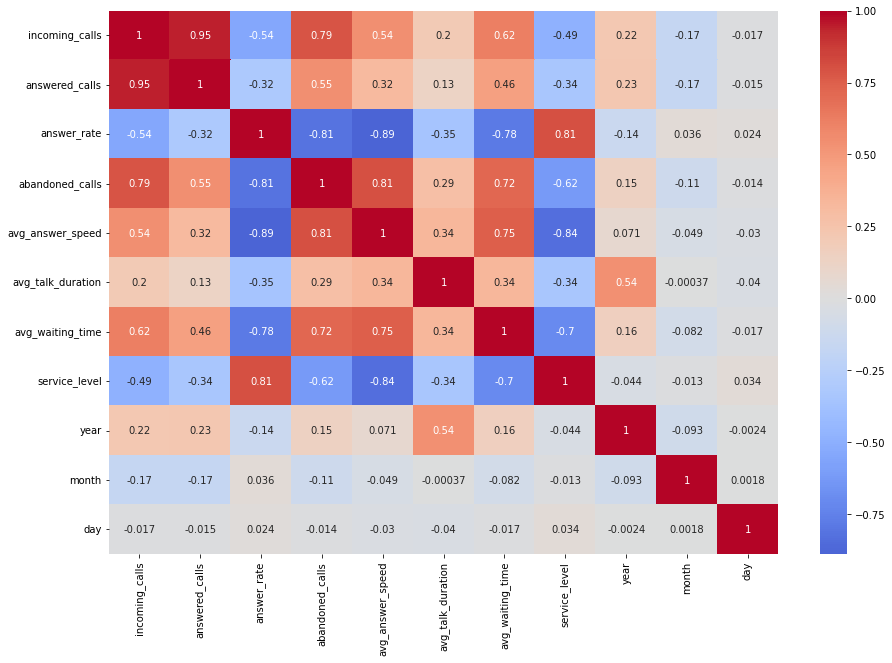

In [49]:
plt.figure(figsize=(15, 10))
sns.color_palette("dark", as_cmap=True)
sns.heatmap(df_lgbm.corr(), annot=True, cmap="coolwarm", center = 0)

In [50]:
#Prep data for model
df_prepared = df_lgbm.copy()
df_prepared['Date'] = pd.to_datetime(df_lgbm['Date'])
df_prepared = df_prepared.set_index(df_prepared.Date)
df_prepared = df_prepared.drop(['Date', 'Day_of_week'], axis = 1)
df_prepared

,incoming_calls,answered_calls,answer_rate,abandoned_calls,avg_answer_speed,avg_talk_duration,avg_waiting_time,service_level,year,month,day
Date,,,,,,,,,,,
2015-01-01,217,204,0.94,13,17.0,134.0,165.0,0.76,2015,1,3
2015-01-02,200,182,0.91,18,20.0,142.0,415.0,0.73,2015,1,4
2015-01-05,216,198,0.92,18,18.0,158.0,230.0,0.74,2015,1,0
2015-01-06,155,145,0.94,10,15.0,149.0,192.0,0.80,2015,1,1
2015-01-07,37,37,1.00,0,3.0,126.0,35.0,0.97,2015,1,2
...,...,...,...,...,...,...,...,...,...,...,...
2019-10-11,191,184,0.96,7,7.0,170.0,116.0,0.93,2019,10,4
2019-10-14,212,209,0.99,3,10.0,171.0,105.0,0.89,2019,10,0
2019-10-15,210,203,0.97,7,12.0,202.0,232.0,0.85,2019,10,1


In [69]:
def train_time_series(df_prepared, horizon=90):
  X = df_prepared.drop(['incoming_calls'], axis=1)
  y = df_prepared['incoming_calls']

  X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
  y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

  model = LGBMRegressor(random_state=42)
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)

  mae = np.round(np.mean(np.abs(predictions - y_test)),3)
  rmse = np.round(np.mean((predictions - y_test)**2)**0.5,3)
  mape = np.round(np.mean((predictions - y_test)/y_test),3)

  fig = plt.figure(figsize=(16,8))
  plt.title(f'Prediction vs. Real - MAE {mae} - RMSE {rmse} - MAPE {mape}', fontsize=16)
  plt.plot(y_test, color='red')
  plt.plot(pd.Series(predictions, index=y_test.index), color='green')
  plt.xlabel('Date', fontsize=16)
  plt.ylabel('Number of Incoming Calls', fontsize=16)
  plt.legend(labels=['Real', 'Prediction'], fontsize=16)
  plt.grid()
  plt.show()

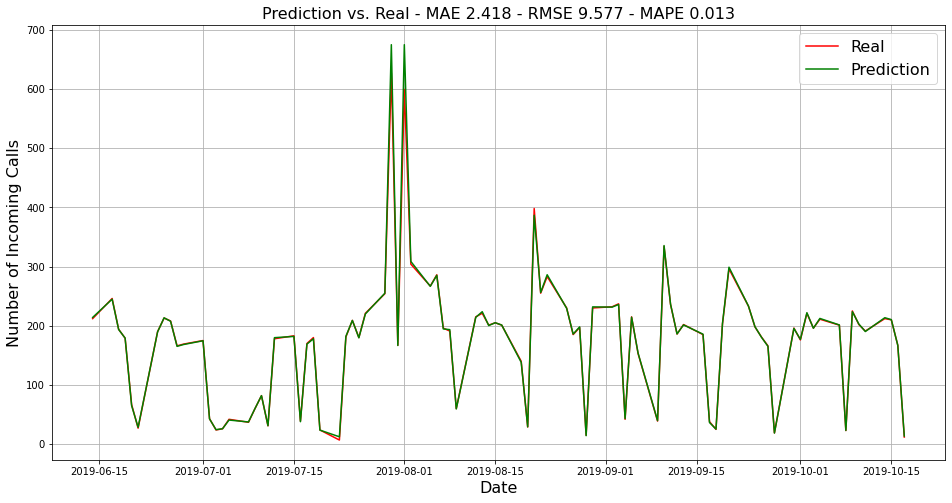

In [70]:
train_time_series(df_prepared)

In [66]:
#K-Fold Cross Validation
horizon = 90
model = LGBMRegressor(random_state=42)

X = df_prepared.drop(['incoming_calls'], axis=1)
y = df_prepared['incoming_calls']

X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]

cross_val_scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=10)
model_mse_scores = np.sqrt(-cross_val_scores)

In [67]:
def display_scores(cross_val_scores):
  print("Scores:", cross_val_scores)
  print("Mean:", cross_val_scores.mean())
  print("Standard Deviation:", cross_val_scores.std())

display_scores(model_mse_scores)

Scores: [  1.84517452  15.32208029   3.07741571   3.69861844   3.03407786
  17.93386669 101.34110029  37.65918362  15.1537262    9.60302244]
Mean: 20.866826604366153
Standard Deviation: 28.719317424085997


In [73]:
df_prepared.to_csv('call_center_prepared.csv')
!cp call_center_prepared.csv "/content/drive/MyDrive/"